In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

## prepare

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(
        datasets.CIFAR10(
          root='./data',
          train=True,
          download=True,
          transform=transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize(
                [0.5, 0.5, 0.5],  # RGB 平均
                [0.5, 0.5, 0.5]   # RGB 標準偏差
                )
          ])),
        batch_size=128,
        shuffle=True
    )
 
test_loader = DataLoader(
    datasets.CIFAR10(
      root='./data',
      train=False,
      download=True,
      transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(
              [0.5, 0.5, 0.5],  # RGB 平均
              [0.5, 0.5, 0.5]  # RGB 標準偏差
          )
      ])),
    batch_size=128,
    shuffle=False
)

plane


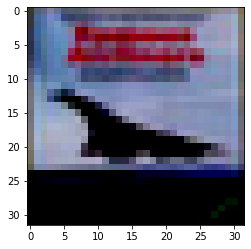

In [17]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  # CIFAR10のクラス

dataiter = iter(test_loader)
sample_datas, lables = next(dataiter)

index = 3

print( classes[lables[index]] )

first_image = sample_datas[index]

# convert the image tensor to a numpy array
first_image = first_image.numpy()

# transpose the image array to match the expected shape of matplotlib
first_image = np.transpose(first_image, (1, 2, 0))

# plot the image using pyplot
plt.imshow(first_image)
plt.show()

## model train

In [18]:
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super(ConvolutionalNeuralNetwork, self).__init__()

    self.conv1 = nn.Conv2d(
        3,    # input channel size
        6,    # output channel size
        5     # kernel size
    )
    self.pool = nn.MaxPool2d(
        2,    # kernel size
        2     # stride
    )
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(
        16 * 5 * 5,   # input size  (fixed)
        120           # output size
    )
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # -> n, 3, 32, 32
    x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
    x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
    x = x.view(-1, 16 * 5 * 5)            # -> n, 400
    x = F.relu(self.fc1(x))               # -> n, 120
    x = F.relu(self.fc2(x))               # -> n, 84
    x = self.fc3(x)                       # -> n, 10
    return x

model = ConvolutionalNeuralNetwork().to(device)


learning_rate = 0.0005
num_epochs = 5

# loss
criterion = nn.CrossEntropyLoss() # softmax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# save
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(4):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Finished Training
Accuracy of the network: 10.34 %
Accuracy of plane: 0.0 %
Accuracy of car: 0.0 %
Accuracy of bird: 0.0 %
Accuracy of cat: 0.0 %
Accuracy of deer: 0.0 %
Accuracy of dog: 0.0 %
Accuracy of frog: 0.0 %
Accuracy of horse: 100.0 %
Accuracy of ship: 9.375 %
Accuracy of truck: 0.0 %
